### Importing relevant libraries 

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
#to encode the categorical data into numerical values
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### Loading the data 

In [4]:
data=pd.read_csv("mushrooms-full-dataset.csv",dtype=str)

### Exploratory Data Analysis

In [6]:
data.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [7]:
data['poisonous'].value_counts()

e    4208
p    3916
Name: poisonous, dtype: int64

In [8]:
data.isnull().sum()

poisonous                   0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

### Preprocessing

#### Defining target and inputs

In [9]:
target=data['poisonous']
inputs=data.drop(['poisonous'],axis=1)

#### Train test split

In [10]:
x_train,x_test,y_train,y_test=train_test_split(inputs,
                                               target,
                                               test_size=0.2,
                                               random_state=42,
                                               stratify=target)
#the last parameter ensures that the distribution of the variable remains the same after the split

#### Check stratification results

In [11]:
y_train.value_counts()

e    3366
p    3133
Name: poisonous, dtype: int64

In [12]:
y_test.value_counts()

e    842
p    783
Name: poisonous, dtype: int64

### Encoding Cetegorical into Numerical 

#### Define a separate encoder for the taret and the inputs

In [13]:
enc_i=OrdinalEncoder()#turns each categorical value into numerical
enc_t=LabelEncoder()#ensures we preserve the values of our original targets for the interpretation
# we can also one hot encode the variables

#### Apply the fit_transform() method on the training data and the transform() method on the test data

In [14]:
x_train_transf=enc_i.fit_transform(x_train)
x_test_transf=enc_i.transform(x_test)

y_train_transf=enc_t.fit_transform(y_train)
y_test_transf=enc_t.transform(y_test)

### Rescaling (Unique step to SVMs)

In [15]:
#in order for the Support Vector Classifier to work the inputs need to be in the range [-1,1]
scaler=MinMaxScaler(feature_range=(-1,1)).fit(x_train_transf)
x_train_rescaled=scaler.transform(x_train_transf)

### Classification

In [16]:
# the c_value
c=1.0 #in practice we start with 1
svc=svm.SVC(kernel="linear", C=c).fit(x_train_rescaled,y_train_transf)

In [17]:
y_pred_test=svc.predict(scaler.transform(x_test_transf))

### Model evaluation

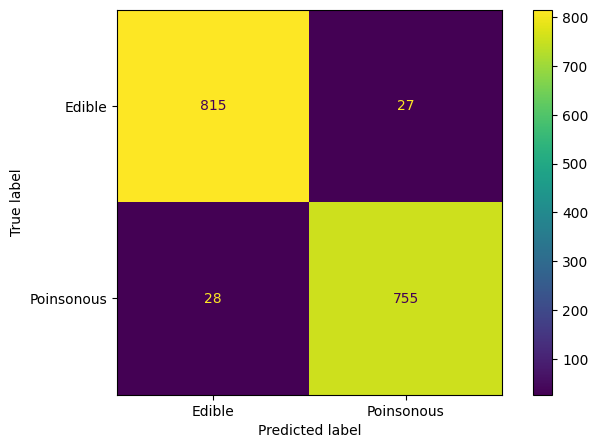

In [28]:
fig,ax=plt.subplots(figsize=(8,5))

cmp=ConfusionMatrixDisplay(
    confusion_matrix(y_test_transf,y_pred_test),
    display_labels=["Edible","Poinsonous"],
)
cmp.plot(ax=ax)

In [29]:
print(classification_report(y_test_transf,y_pred_test,target_names=["Edible","Poisonous"]))

              precision    recall  f1-score   support

      Edible       0.97      0.97      0.97       842
   Poisonous       0.97      0.96      0.96       783

    accuracy                           0.97      1625
   macro avg       0.97      0.97      0.97      1625
weighted avg       0.97      0.97      0.97      1625



pretty good results overall. what we need from the model is susccessfully detect the poisonous mushrooms, so our metric is the recall for the poisonous value, which is 0.96, which means the model misclassified around 4% of the poisonous mushrooms as edible

### Hyperparameter Tuning with GridSearchCV

#### Choose the best kernel and optimal C parameter based on Cross Validation of the training data

In [30]:
tuned_parameters=[
    {"kernel":["linear"],"C":[1,10]},
    {"kernel":["poly"],"C":[1,10]},
    {"kernel":["rbf"],"gamma":[1e-3,1e-4],"C":[1,10]}
]

In [31]:
scores = ["precision", "recall"]

In [33]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(x_train_rescaled, y_train_transf)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_transf, clf.predict(scaler.transform(x_test_transf))
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'kernel': 'poly'}

Grid scores on development set:

0.951 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.959 (+/-0.008) for {'C': 10, 'kernel': 'linear'}
1.000 (+/-0.001) for {'C': 1, 'kernel': 'poly'}
1.000 (+/-0.000) for {'C': 10, 'kernel': 'poly'}
0.926 (+/-0.010) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.895 (+/-0.011) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.947 (+/-0.007) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.926 (+/-0.010) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.